2장

2.2 퍼셉트론 학습 알고리즘 구현

In [1]:
#객체지향 퍼셉트론 

#numpy모듈 import
import numpy as np

class Perceptron( object ):
    #매개변수
    #  eta : (float) 학습률 (0.0~1.0)
    #  n_iter : (int) 훈련 데이터셋 반복횟수
    #  random_state : (int) 가중치 무작위 초기화를 위한 난수 생성기 시드
    
    #속성
    #  w_ : (1d-array) 학습된 가중치
    #  errors_ : (list) 에포크마다 누적된 분류 오류
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit( self, X, y ):
        #훈련 데이터 학습
        
        #매개변수
        #X : n개의 샘플과 n개의 특성으로 이루어진 훈련데이터.
        #y : 타깃값
        rgen = np.random.RandomState( self.random_state )
        self.w_ = rgen.normal(
            loc = 0.0,
            scale = 0.01,
            size = 1 + X.shape[1] 
        )
        self.errors_=[]
        
        for _ in range( self.n_iter ):
            errors = 0
            for xi, target in zip( X, y ):
                update = self.eta * ( target - self.predict(xi) )
                self.w_[1:] += update*xi
                self.w_[0] += update
                errors += int(update!=0.0)
            self.errors_.append( errors )
        return self
    
    def net_input( self, X ):
        #입력 계산
        return np.dot( X, self.w_[1:] + self.w_[0] )
    
    def predict(self, X):
        #단위계산 함수를 사용하여 클래스 레이블을 반환
        return np.where( self.net_input(X) >= 0.0, 1, -1 )

붓꽃 데이터셋 다운로드 주소

    https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

In [2]:
#붓꽃 데이터를 다운로드 받아서 data 폴더에 저장. 판다스 read_csv로 읽어오기
import os
import pandas as pd

df = pd.read_csv("./data/iris_data.csv",header=None, encoding="utf-8")

print(df)

       0    1    2    3               4
0    5.1  3.5  1.4  0.2     Iris-setosa
1    4.9  3.0  1.4  0.2     Iris-setosa
2    4.7  3.2  1.3  0.2     Iris-setosa
3    4.6  3.1  1.5  0.2     Iris-setosa
4    5.0  3.6  1.4  0.2     Iris-setosa
..   ...  ...  ...  ...             ...
145  6.7  3.0  5.2  2.3  Iris-virginica
146  6.3  2.5  5.0  1.9  Iris-virginica
147  6.5  3.0  5.2  2.0  Iris-virginica
148  6.2  3.4  5.4  2.3  Iris-virginica
149  5.9  3.0  5.1  1.8  Iris-virginica

[150 rows x 5 columns]


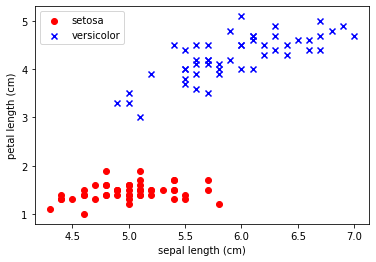

In [3]:
#산점도 그래프로 데이터셋 시각화
import matplotlib.pyplot as plt
import numpy as np

y = df.iloc[0:100, 4].values
y = np.where(y == "Iris-setosa", -1, 1)

X = df.iloc[0:100, [0,2]].values

plt.scatter(X[:50, 0], X[:50, 1], color="red", marker="o", label="setosa")
plt.scatter(X[50:100, 0], X[50:100, 1], color="blue", marker="x", label="versicolor")

plt.xlabel("sepal length (cm)")
plt.ylabel("petal length (cm)")
plt.legend(loc="upper left")

plt.show()

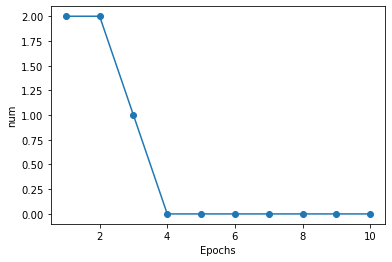

In [4]:
#에포크 대비 잘못 분류된 오차 그래프로 나타내기
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

plt.plot(
    range(1, len(ppn.errors_) + 1),
    ppn.errors_,
    marker="o"
)

plt.xlabel("Epochs")
plt.ylabel("num")

plt.show()

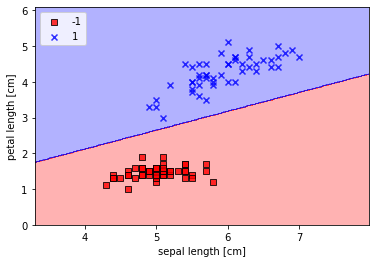

In [5]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_08.png', dpi=300)
plt.show()

2.3 적응형 선형 뉴런과 학습의 수렴

In [6]:
class AdalineGD(object):
    #매개변수
    #  eta : (float) 학습률 (0.0~1.0)
    #  n_iter : (int) 훈련 데이터셋 반복횟수
    #  random_state : (int) 가중치 무작위 초기화를 위한 난수 생성기 시드
    
    #속성
    #  w_ : (1d-array) 학습된 가중치
    #  errors_ : (list) 에포크마다 누적된 분류 오류
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        #훈련 데이터 학습
        
        #매개변수
        #X : n개의 샘플과 n개의 특성으로 이루어진 훈련데이터.
        #y : 타깃값
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(
            loc=0.0,
            scale=0.01,
            size=1+X.shape[1] 
        )
        #self.errors_=[]
        self.cost_=[]
        
        for i in range(self.n_iter):
            net_input=self.net_input(X)
            output=self.activation(net_input)
            errors=(y-output)
            self.w_[1:]+=self.eta*X.T.dot(errors)
            self.w_[0]+=self.eta*errors.sum()
            cost=(errors**2).sum() / 2.0
            self.cost_.append(cost)
            
        return self
    
    def net_input(self, X):
        #입력 계산
        return np.dot(X, self.w_[1:] + self.w_[0])
    
    def predict(self, X):
        #단위계산 함수를 사용하여 클래스 레이블을 반환
        return np.where(
            self.activation( self.net_input(X)) >= 0.0, 1, -1
        )
    
    def activation(self, X):
        #선형 활성화 계산
        return X

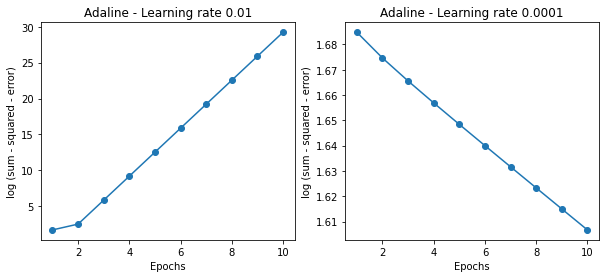

In [7]:
#학습률(eta)에 따라 에포크 횟수 대비 비용 그래프
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# eta=0.01인 경우
ada1 = AdalineGD(n_iter=10,eta=0.01).fit(X,y)
ax[0].plot(range(1, len(ada1.cost_)+1), np.log10(ada1.cost_),marker="o")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log (sum - squared - error)")
ax[0].set_title("Adaline - Learning rate 0.01")

# eta=0.0001인 경우
ada2 = AdalineGD(n_iter=10,eta=0.0001).fit(X,y)
ax[1].plot(range(1, len(ada2.cost_)+1), np.log10(ada2.cost_),marker="o")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("log (sum - squared - error)")
ax[1].set_title("Adaline - Learning rate 0.0001")

plt.show()

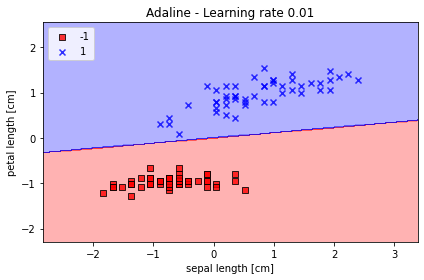

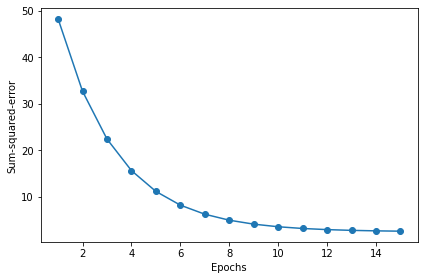

In [8]:
#특성 스케일 조정하여 경사하강법 결과 향상
x_std = np.copy(X)
x_std[:,0] = ( X[:,0] - X[:,0].mean() ) / X[:,0].std()
x_std[:,1] = ( X[:,1] - X[:,1].mean() ) / X[:,1].std()

ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(x_std, y)

plot_decision_regions(x_std, y, classifier=ada)
plt.title("Adaline - Learning rate 0.01")
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(
    range(1,len(ada.cost_) + 1 ), ada.cost_, marker="o"
)
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

In [44]:
#대규모 머신러닝과 확률적 경사 하강법
class AdalineSGD(object):
    
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
    
    def fit(self, X, y):
        #훈련 데이터 학습함수
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        #가중치를 초기화 하지 않고 다시 학습
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        
        return self
    
    def _shuffle(self, X, y):
        #훈련 데이터를 섞기
        r= self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        #랜덤한 작은 수치로 가중치 초기화
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(
            loc=0.0,
            scale=0.01,
            size=1+m
        )
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        #아달린 학습 규칙을 이용하여 가중치 업데이트
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error ** 2
        return cost
    
    def net_input(self, X):
        #입력 계산
        return np.dot(X, self.w_[1:] + self.w_[0])
    
    def activation(self, X):
        #선형 활성화 계산
        return X 
    
    def predict(self, X):
        #단위계산 함수를 사용하여 클래스 레이블을 반환
        return np.where(
            self.activation( self.net_input(X)) >= 0.0, 1, -1
        )

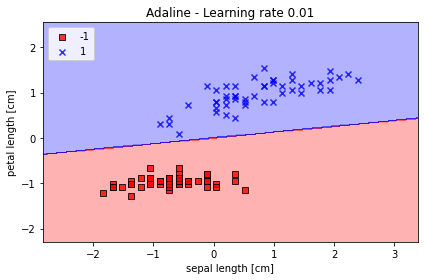

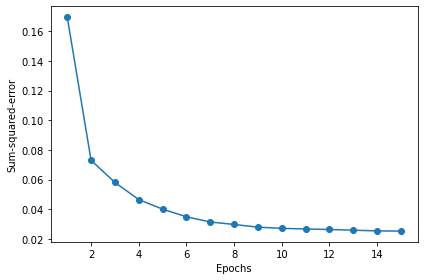

In [46]:
#
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(x_std, y)

plot_decision_regions(x_std, y, classifier=ada)
plt.title("Adaline - Learning rate 0.01")
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(
    range(1,len(ada.cost_) + 1 ), ada.cost_, marker="o"
)
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

3장

3.2 사이킷런 첫걸음 : 퍼셉트론 훈련

In [47]:
#
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
print("클래스 레이블:",np.unique(y))

클래스 레이블: [0 1 2]


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.3, 
    random_state = 1, 
    stratify = y
)

print("y의 레이블 카운트:", np.bincount(y))
print("y_train의 레이블 카운트:", np.bincount(y_train))
print("y_test의 레이블 카운트:", np.bincount(y_test))

y의 레이블 카운트: [50 50 50]
y_train의 레이블 카운트: [35 35 35]
y_test의 레이블 카운트: [15 15 15]


In [50]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [56]:
from sklearn.linear_model import Perceptron
ppn = Perceptron( eta0 = 0.1, random_state=1)
ppn.fit(X_train_std, y_train)

y_pred = ppn.predict(X_test_std)
print("잘못 분류된 샘플 개수:%d" % (y_test != y_pred).sum())

print("정확도:%.3f" % ppn.score(X_test_std, y_test))

잘못 분류된 샘플 개수:1


In [65]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx = None, resolution = 0.02):
    
    #Marker와 Colormap 설정
    marker = ("s","x","o","^","v")
    colors = ("red","blue","lightgreen","gray","cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #결정 경계 write
    x1_min, x1_max = X[:,0].min() - 1 , X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1 , X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    
    Z = classifier.predict(
        np.array(
            [xx1.ravel(), xx2.ravel()]
        ).T
    )
    
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y==cl,0],
            y=X[y==cl,1],
            alpha=0.8,
            c=colors[idx],
            marker=marker[idx],
            label=cl,
            edgecolor="black"
        )
        
    #테스트 샘플을 부각하며 그립니다.
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(
            X_test[:,0],
            X_test[:,1],
            facecolors = "none",
            edgecolor = "black",
            alpha = 1.0,
            linewidth = 1,
            marker = "o",
            s = 100,
            label = "test set"
        )

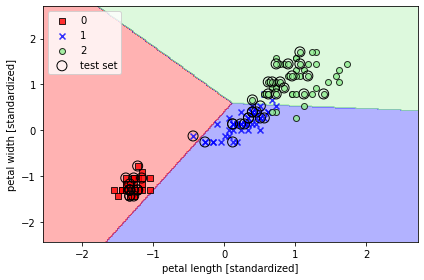

In [67]:
x_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(
    X = x_combined_std,
    y = y_combined,
    classifier = ppn,
    test_idx = range(105,150)
)

plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

3.3 로지스틱 회귀를 사용한 클래스 확률 모델링

In [93]:
#아달린 구현을 로지스틱 회귀 알고리즘으로 변경
class LogisticRegressionGD(object):
    
    def __init__(
        self,
        eta = 0.05,
        n_iter = 100,
        random_state = 1
    ):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(
            loc = 0.0,
            scale = 0.01,
            size = 1 + X.shape[1]
        )
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            #제곱 오차합 대신 로지스틱 비용을 계산한다.
            cost = (-y.dot(np.log(output)) - 
                ((1-y).dot(np.log(1-output)))
            )
            self.cost_.append(cost)
            
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        return np.where(
            self.net_input(X) >= 0.0, 1, 0
        )

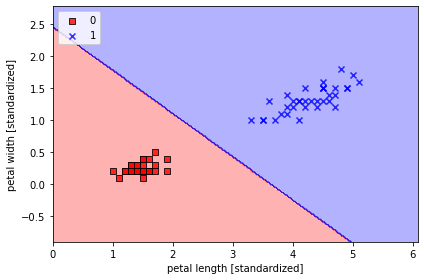

In [95]:
X_train_subset = X_train[(y_train==0)|(y_train==1)]
y_train_subset = y_train[(y_train==0)|(y_train==1)]

lrgd = LogisticRegressionGD(
    eta = 0.05,
    n_iter = 1000,
    random_state = 1
)

lrgd.fit(
    X_train_subset,
    y_train_subset
)

plot_decision_regions(
    X_train_subset,
    y_train_subset,
    classifier = lrgd
)

plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

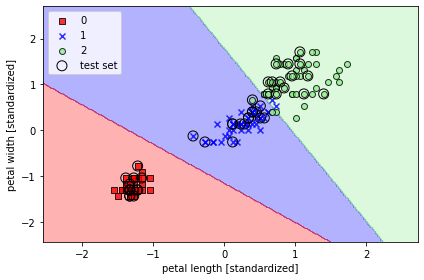

In [96]:
#사이킷런을 사용하여 로지스킥 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
plot_decision_regions(
    x_combined_std,
    y_combined,
    classifier = lr,
    test_idx = range(105, 150)
)
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

3.4 서포트 백터 머신 (SVM) 을 사용한 최대 마진 분류

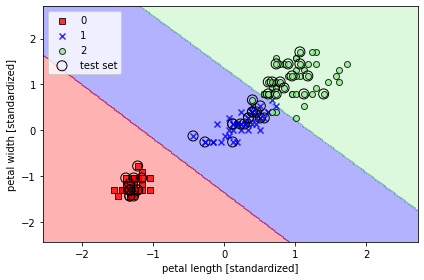

In [97]:
#슬랙 변수를 사용하여 비선형 분류 문제 다루기
from sklearn.svm import SVC
svm = SVC(
    kernel = "linear",
    C = 1.0,
    random_state = 1
)
svm.fit(X_train_std, y_train)
plot_decision_regions(
    x_combined_std,
    y_combined,
    classifier = svm,
    test_idx = range(105, 150)
)
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

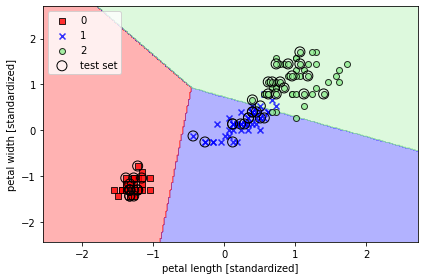

In [118]:
#사이킷런의 다른 구현
from sklearn.linear_model import SGDClassifier

#퍼셉트론
ppn = SGDClassifier(loss = "perceptron")
#로지스틱 회귀
log = SGDClassifier(loss = "log")
#서포트 백터 머신
svm = SGDClassifier(loss = "hinge")

ml = ppn
#ml = log
#ml = svm

ml.fit(X_train_std, y_train)
plot_decision_regions(
    x_combined_std,
    y_combined,
    classifier = ml,
    test_idx = range(105, 150)
)
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

3.5 커널 SVM을 사용하여 비선형 문제 풀기